In [1]:
import glob 
import numpy as np 
import os 
import shutil 
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator,  load_img, img_to_array, array_to_img 
np.random.seed(42) 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,recall_score

import matplotlib.pyplot as plt 

In [2]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

In [3]:
IM_SHAPE=(150,150)

In [4]:
filesCOV= glob.glob('D:/dataset/ALL/COVID-19/*')
filesNOCOV=glob.glob('D:/dataset/ALL/Normal/images/*')


In [5]:
COVID = [fn for fn in filesCOV if 'covid' in fn] 
HEALTHY = [fn for fn in filesNOCOV if 'sano' in fn] 

len(COVID), len(HEALTHY)


(11956, 10701)

In [6]:
COVID_train = np.random.choice(filesCOV, size=1250, replace=False) 
HEALTHY_train = np.random.choice(filesNOCOV, size=1250, replace=False) 
filesCOV = list(set(filesCOV) - set(COVID_train)) 
filesNOCOV = list(set(filesNOCOV) - set(HEALTHY_train)) 
 
COVID_val = np.random.choice(filesCOV, size=1000, replace=False) 
HEALTHY_val = np.random.choice(filesNOCOV, size=1000, replace=False) 
filesCOV = list(set(filesCOV) - set(COVID_val)) 
filesNOCOV = list(set(filesNOCOV) - set(HEALTHY_val)) 
 
#COVID_test = np.random.choice(filesCOV, size=1000, replace=False) 
#HEALTHY_test = np.random.choice(filesNOCOV, size=1000, replace=False) 
 
print('Cat datasets:', COVID_train.shape, COVID_val.shape) 
print('Dog datasets:', HEALTHY_train.shape, HEALTHY_val.shape) 

Cat datasets: (1250,) (1000,)
Dog datasets: (1250,) (1000,)


In [7]:
train_dir = 'D:/dataset/DATAOG/train' 
val_dir = 'D:/dataset/DATAOG/valid'
#test_dir = 'C:/Users/hecto/Downloads/MachineCrypto/Proyecto/test' 
 
    
train_files = np.concatenate([COVID_train, HEALTHY_train]) 
validate_files = np.concatenate([COVID_val, HEALTHY_val]) 
#test_files = np.concatenate([COVID_test, HEALTHY_test])
os.mkdir(train_dir) if not os.path.isdir(train_dir) else None 
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None 
#os.mkdir(test_dir) if not os.path.isdir(test_dir) else None 
 
for fn in train_files: 
    shutil.copy(fn, train_dir) 
for fn in validate_files: 
    shutil.copy(fn, val_dir) 
#for fn in test_files: 
#    shutil.copy(fn, test_dir) 
 

In [8]:
IMG_DIM = IM_SHAPE
 
train_files = glob.glob('D:/dataset/DATAOG/train/*') 
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img  
              in train_files] 
train_imgs = np.array(train_imgs) 
train_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in 
                train_files] 

validation_files = glob.glob('D:/dataset/DATAOG/valid/*') 
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for 
                   img in validation_files] 
validation_imgs = np.array(validation_imgs) 
validation_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in 
                     validation_files] 
 
print('Train dataset shape:', train_imgs.shape,  
      'Validation dataset shape:', validation_imgs.shape) 

Train dataset shape: (2500, 150, 150, 3) Validation dataset shape: (2000, 150, 150, 3)


(150, 150, 3)


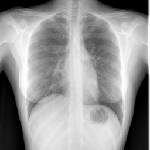

In [9]:
train_imgs_scaled = train_imgs.astype('float32') 
validation_imgs_scaled = validation_imgs.astype('float32') 
train_imgs_scaled /= 255 
validation_imgs_scaled /= 255 
 
# visualize a sample image 
print(train_imgs[0].shape) 
array_to_img(train_imgs[0]) 

In [10]:
for i in range(2500):
    if train_labels[i].find("sano")==-1:
        train_labels[i]='covid'
    else :
        train_labels[i]='sano'
for i in range(2000):
    if validation_labels[i].find("sano")==-1:
        validation_labels[i]='covid'
    else :
        validation_labels[i]='sano'
        

In [11]:
batch_size = 8
num_classes = 2 
epochs = 30 
input_shape = (IM_SHAPE[0],IM_SHAPE[1], 3) 
 
# encode text category labels 
from sklearn.preprocessing import LabelEncoder 
 
le = LabelEncoder() 
le.fit(train_labels) 
train_labels_enc = le.transform(train_labels) 
validation_labels_enc = le.transform(validation_labels) 
 
print(train_labels[190:195], train_labels_enc[195:200]) 

['covid', 'covid', 'covid', 'covid', 'covid'] [0 0 0 0 0]


In [12]:
input_shape

(150, 150, 3)

In [13]:
from keras.applications import ResNet50
from keras.models import Model 
import keras 
resnet=ResNet50(include_top=False,weights='imagenet',  
                                     input_shape=input_shape)

# we have removed the final part of the classifier pertaining to the VGG-16 model 
#since we will be building our own classifier and leveraging VGG as a feature extractor
output = resnet.layers[-1].output 
output = keras.layers.Flatten()(output) 
resnet_model = Model(resnet.input, output) 
resnet_model.trainable = False 
 
for layer in resnet_model.layers: 
    layer.trainable = False 

resnet_model.summary()

94765736/94765736 [==============================] - 8s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization

 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 38, 38, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 38, 38, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 38, 38, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 19, 19, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 19, 19, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 19, 19, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

 conv4_block5_1_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization)                                                                                         
          

 conv5_block1_out (Activation)  (None, 5, 5, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 5, 5, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 5, 5, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 5, 5, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_blo

In [14]:
# To verify that the layers of the VGG-16 model are frozen, we can use the following code:
import pandas as pd 
pd.set_option('max_colwidth', -1) 
 
layers = [(layer, layer.name, layer.trainable) for layer in 
           resnet_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

C:\Users\hecto\AppData\Local\Temp\ipykernel_1848\3903062396.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000001DDF8433DC0>,input_1,False
1,<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x000001DDF86A9D60>,conv1_pad,False
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x000001DDF847A3A0>,conv1_conv,False
3,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DE680573A0>,conv1_bn,False
4,<keras.layers.core.activation.Activation object at 0x000001DDF848A1C0>,conv1_relu,False
...,...,...,...
171,<keras.layers.convolutional.conv2d.Conv2D object at 0x000001DDCE3676A0>,conv5_block3_3_conv,False
172,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001DDCE2FDA60>,conv5_block3_3_bn,False
173,<keras.layers.merging.add.Add object at 0x000001DDCE35D2B0>,conv5_block3_add,False
174,<keras.layers.core.activation.Activation object at 0x000001DDCE2F2EB0>,conv5_block3_out,False


In [15]:
print("Trainable layers:", resnet_model.trainable_weights)


Trainable layers: []


1/1 [==============================] - 3s 3s/step
(1, 5, 5, 2048)


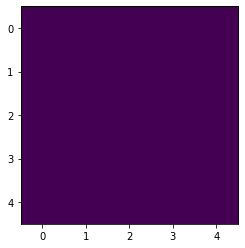

In [16]:
bottleneck_feature_example = resnet.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape) 
plt.imshow(bottleneck_feature_example[0][:,:,0]) 

In [17]:
def get_bottleneck_features(model, input_imgs): 
    features = model.predict(input_imgs, verbose=1, batch_size=32) 
    return features 

train_features_resnet = get_bottleneck_features(resnet_model, 
                                             train_imgs_scaled) 
validation_features_resnet= get_bottleneck_features(resnet_model,      
                                                validation_imgs_scaled) 

print('Train Bottleneck Features:', train_features_resnet.shape, 
      '\tValidation Bottleneck Features:', validation_features_resnet.shape) 

63/63 [==============================] - 4s 67ms/step
Train Bottleneck Features: (2500, 51200) 	Validation Bottleneck Features: (2000, 51200)


In [18]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier

In [19]:
X_train=train_features_resnet
y_train=train_labels_enc
X_valid=validation_features_resnet
y_valid=validation_labels_enc


In [20]:
Acc=[]
Rec=[]
Pre=[]
F1=[]

In [21]:
hist=BaggingClassifier(
base_estimator=DecisionTreeClassifier(),
n_estimators=5
)
hist.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=5)

In [22]:
hist1=RandomForestClassifier(n_estimators=5)
hist1.fit(X_train,y_train)

RandomForestClassifier(n_estimators=5)

In [23]:
hist2=XGBClassifier()
hist2.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [24]:
hist3=LGBMClassifier(n_estimators=1000,class_weight='balanced',
                                       reg_alpha=0.1,reg_lambda=0.1,
                                       learning_rate=0.001,num_leaves=400,boosting='dart'
)
hist3.fit(X_train,y_train)

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


LGBMClassifier(boosting='dart', class_weight='balanced', learning_rate=0.001,
               n_estimators=1000, num_leaves=400, reg_alpha=0.1,
               reg_lambda=0.1)

In [25]:
hist4=AdaBoostClassifier(
base_estimator=DecisionTreeClassifier(),
n_estimators=300
)
hist4.fit(X_train,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=300)

In [26]:
hist5=DecisionTreeClassifier()
hist5.fit(X_train,y_train)

DecisionTreeClassifier()

In [27]:
cm2 = confusion_matrix(y_valid,hist.predict(X_valid))
print(cm2)
acc=accuracy_score(y_valid, hist.predict(X_valid))
print("Accuracy: ",(acc))
recall=recall_score(y_valid, hist.predict(X_valid))
print("Recall: ",(recall))
prec=precision_score(y_valid,hist.predict(X_valid))
print("Precision: ",(prec))
f1=f1_score(y_valid,hist.predict(X_valid))
Acc.append(acc)
Rec.append(recall)
Pre.append(prec)
F1.append(f1)
print("F1-score: ",(f1))

[[779 221]
 [230 770]]
Accuracy:  0.7745
Recall:  0.77
Precision:  0.7769929364278506
F1-score:  0.7734806629834253


In [28]:
cm2 = confusion_matrix(y_valid,hist1.predict(X_valid))
print(cm2)
acc=accuracy_score(y_valid, hist1.predict(X_valid))
print("Accuracy: ",(acc))
recall=recall_score(y_valid, hist1.predict(X_valid))
print("Recall: ",(recall))
prec=precision_score(y_valid,hist1.predict(X_valid))
print("Precision: ",(prec))
f1=f1_score(y_valid,hist1.predict(X_valid))
print("F1-score: ",(f1))
Acc.append(acc)
Rec.append(recall)
Pre.append(prec)
F1.append(f1)

[[712 288]
 [273 727]]
Accuracy:  0.7195
Recall:  0.727
Precision:  0.716256157635468
F1-score:  0.7215880893300247


In [29]:
cm2 = confusion_matrix(y_valid,hist2.predict(X_valid))
print(cm2)
acc=accuracy_score(y_valid, hist2.predict(X_valid))
print("Accuracy: ",(acc))
recall=recall_score(y_valid, hist2.predict(X_valid))
print("Recall: ",(recall))
prec=precision_score(y_valid,hist2.predict(X_valid))
print("Precision: ",(prec))
f1=f1_score(y_valid,hist2.predict(X_valid))
print("F1-score: ",(f1))
Acc.append(acc)
Rec.append(recall)
Pre.append(prec)
F1.append(f1)

[[906  94]
 [143 857]]
Accuracy:  0.8815
Recall:  0.857
Precision:  0.9011566771819137
F1-score:  0.8785238339313172


In [30]:
cm2 = confusion_matrix(y_valid,hist3.predict(X_valid))
print(cm2)
acc=accuracy_score(y_valid, hist3.predict(X_valid))
print("Accuracy: ",(acc))
recall=recall_score(y_valid, hist3.predict(X_valid))
print("Recall: ",(recall))
prec=precision_score(y_valid,hist3.predict(X_valid))
print("Precision: ",(prec))
f1=f1_score(y_valid,hist3.predict(X_valid))
print("F1-score: ",(f1))
Acc.append(acc)
Rec.append(recall)
Pre.append(prec)
F1.append(f1)

[[795 205]
 [229 771]]
Accuracy:  0.783
Recall:  0.771
Precision:  0.7899590163934426
F1-score:  0.7803643724696356


In [31]:
cm2 = confusion_matrix(y_valid,hist4.predict(X_valid))
print(cm2)
acc=accuracy_score(y_valid, hist4.predict(X_valid))
print("Accuracy: ",(acc))
recall=recall_score(y_valid, hist4.predict(X_valid))
print("Recall: ",(recall))
prec=precision_score(y_valid,hist4.predict(X_valid))
print("Precision: ",(prec))
f1=f1_score(y_valid,hist4.predict(X_valid))
print("F1-score: ",(f1))
Acc.append(acc)
Rec.append(recall)
Pre.append(prec)
F1.append(f1)

[[738 262]
 [246 754]]
Accuracy:  0.746
Recall:  0.754
Precision:  0.7421259842519685
F1-score:  0.748015873015873


In [32]:
cm2 = confusion_matrix(y_valid,hist5.predict(X_valid))
print(cm2)
acc=accuracy_score(y_valid, hist5.predict(X_valid))
print("Accuracy: ",(acc))
recall=recall_score(y_valid, hist5.predict(X_valid))
print("Recall: ",(recall))
prec=precision_score(y_valid,hist5.predict(X_valid))
print("Precision: ",(prec))
f1=f1_score(y_valid,hist5.predict(X_valid))
print("F1-score: ",(f1))
Acc.append(acc)
Rec.append(recall)
Pre.append(prec)
F1.append(f1)

[[729 271]
 [253 747]]
Accuracy:  0.738
Recall:  0.747
Precision:  0.7337917485265226
F1-score:  0.7403369672943508


In [33]:
data=pd.DataFrame([Acc,Rec,Pre,F1])

In [34]:
data

,0,1,2,3,4,5
0,0.774500,0.719500,0.881500,0.783000,0.746000,0.738000
1,0.770000,0.727000,0.857000,0.771000,0.754000,0.747000
2,0.776993,0.716256,0.901157,0.789959,0.742126,0.733792
3,0.773481,0.721588,0.878524,0.780364,0.748016,0.740337


In [35]:
pd.DataFrame.to_csv(data,'data.csv')